In [1]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt

import os
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
import pickle
from scipy import signal
from sklearn import metrics
from sklearn import tree, svm

from sklearn import tree, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

In [2]:
def remove_noise(data,sampling_rate):

    # Low pass filter
    cutoff = 10 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data.iloc[:,0] = filtfilt(b, a, data.iloc[:,0])
    data.iloc[:,1] = filtfilt(b, a, data.iloc[:,1])
    data.iloc[:,2] = filtfilt(b, a, data.iloc[:,2])

    return data

def extract_features(data, direction, signal_type):
    feature_names = ["avg_x", "avg_y", "avg_z", 
                 "max_x", "max_y", "max_z",
                 "med_x", "med_y", "med_z", 
                 "min_x", "min_y", "min_z",
                 "std_x", "std_y", "std_z", 
                 "range_x", "range_y", "range_z",
                 "direction"]
    feature_names = [signal_type+"_"+name for name in feature_names[:-1]].append("direction")
    
    data = remove_noise(data, 100)
    
    data.iloc[:,0] = data.iloc[:,0] - data.iloc[:,0].mean()
    data.iloc[:,1] = data.iloc[:,1] - data.iloc[:,1].mean()
    data.iloc[:,2] = data.iloc[:,2] - data.iloc[:,2].mean()
    
    # Average
    avg_x = data.iloc[:, 0].mean()
    avg_y = data.iloc[:, 1].mean()
    avg_z = data.iloc[:, 2].mean()
    # Max
    max_x = data.iloc[:, 0].max()
    max_y = data.iloc[:, 1].max()
    max_z = data.iloc[:, 2].max()
    # Median
    med_x = data.iloc[:, 0].median()
    med_y = data.iloc[:, 1].median()
    med_z = data.iloc[:, 2].median()
    # Min
    min_x = data.iloc[:, 0].min()
    min_y = data.iloc[:, 1].min()
    min_z = data.iloc[:, 2].min()
    # Standard Deviation
    std_x = data.iloc[:, 0].std()
    std_y = data.iloc[:, 1].std()
    std_z = data.iloc[:, 2].std()
    # Range 
    range_x = max_x - min_x
    range_y = max_y - min_y
    range_z = max_z - min_z
    # Jerk - TBD
    
    # Features
    features = pd.DataFrame([[avg_x, avg_y, avg_z, 
                              max_x, max_y, max_z, 
                              med_x, med_y, med_z,
                              min_x, min_y, min_z,
                              std_x, std_y, std_z, 
                              range_x, range_y, range_z,
                              direction]], 
                            columns=feature_names)
        
    return features

def read_file(signal_type, direction, filenames):
    feature_names = ["avg_x", "avg_y", "avg_z", 
                 "max_x", "max_y", "max_z",
                 "med_x", "med_y", "med_z", 
                 "min_x", "min_y", "min_z",
                 "std_x", "std_y", "std_z",
                 "range_x", "range_y", "range_z",
                 "direction", "file_num"]
    feature_names = feature_names = [signal_type+"_"+name for name in feature_names[:-1]].append("direction")
    
    all_data = pd.DataFrame(columns=feature_names)
    
    for file in filenames:
        data = pd.read_csv(file)
        file_num = int(re.search(r'(\d*).csv', file).group(1))
        data = data.iloc[50:380, 1:]
        features = extract_features(data.astype('float'), direction, signal_type)
        
        file_num = pd.DataFrame([[file_num]], columns=['file_num'])
        features = pd.concat([features, file_num], axis=1)
        
        all_data = pd.concat([all_data, features])
    return all_data

def read_gestures_data(gestures, root):
    features = []
    labels = []
    for gesture in gestures:
        ## READ DATA FROM MEMBER 1
        # Read acceleration data
        filenames = glob.glob(root + gesture + "_" + "*")
        for file in filenames:
            data = pd.read_csv(file)
            data = remove_noise(data, 100)
            # Keep only accelerometer and gyroscope signals
            data = data.iloc[50:380,:]
            data = data[['accel_x', 'accel_y', 'accel_z']].to_numpy()
#             data = data[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].to_numpy()

            # Normalize data
            data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

            # Populate lists with normalized data and labels
            if len(data.flatten()) == 330*3:
                features.append(data.flatten())
                labels.append(gesture)
        
    return features, np.array(labels)

In [21]:
def extract_features(data, direction):
    feature_names = ["avg_x", "avg_y", "avg_z", 
                 "max_x", "max_y", "max_z",
                 "med_x", "med_y", "med_z", 
                 "min_x", "min_y", "min_z",
                 "diff_x", "diff_y", "diff_z",
                 "std_x", "std_y", "std_z", 
                 "range_x", "range_y", "range_z",
                 "direction"]
    feature_names = [name for name in feature_names[:-1]].append("direction")
    
    data = remove_noise(data, 100)
    
    data.iloc[:,0] = data.iloc[:,0] - data.iloc[:,0].mean()
    data.iloc[:,1] = data.iloc[:,1] - data.iloc[:,1].mean()
    data.iloc[:,2] = data.iloc[:,2] - data.iloc[:,2].mean()
    
    # Average
    avg_x = data.iloc[:, 0].mean()
    avg_y = data.iloc[:, 1].mean()
    avg_z = data.iloc[:, 2].mean()
    # Max
    max_x = data.iloc[:, 0].max()
    max_y = data.iloc[:, 1].max()
    max_z = data.iloc[:, 2].max()
    # Argmax
    idxmax_x = data.iloc[:, 0].idxmax()
    idxmax_y = data.iloc[:, 1].idxmax()
    idxmax_z = data.iloc[:, 2].idxmax()
    # Median
    med_x = data.iloc[:, 0].median()
    med_y = data.iloc[:, 1].median()
    med_z = data.iloc[:, 2].median()
    # Min
    min_x = data.iloc[:, 0].min()
    min_y = data.iloc[:, 1].min()
    min_z = data.iloc[:, 2].min()
    # Argmin
    idxmin_x = data.iloc[:, 0].idxmin()
    idxmin_y = data.iloc[:, 1].idxmin()
    idxmin_z = data.iloc[:, 2].idxmin()
    # IdxMax - IdxMin
    diff_x = idxmax_x - idxmin_x
    diff_y = idxmax_y - idxmin_y
    diff_z = idxmax_z - idxmin_z
    # Standard Deviation
    std_x = data.iloc[:, 0].std()
    std_y = data.iloc[:, 1].std()
    std_z = data.iloc[:, 2].std()
    # Range 
    range_x = max_x - min_x
    range_y = max_y - min_y
    range_z = max_z - min_z
    # Jerk - TBD
    
    # Features
    features = pd.DataFrame([[avg_x, avg_y, avg_z, 
                              max_x, max_y, max_z,
                              med_x, med_y, med_z,
                              min_x, min_y, min_z,
                              diff_x, diff_y, diff_z,
                              std_x, std_y, std_z, 
                              range_x, range_y, range_z,
                              direction]], 
                            columns=feature_names)
        
    return features

def read_file(direction, filenames):
    feature_names = ["avg_x", "avg_y", "avg_z", 
                 "max_x", "max_y", "max_z",
                 "med_x", "med_y", "med_z", 
                 "min_x", "min_y", "min_z",
                 "diff_x", "diff_y", "diff_z",
                 "std_x", "std_y", "std_z", 
                 "range_x", "range_y", "range_z",
                 "direction", "file_num"]
    feature_names = feature_names = [name for name in feature_names[:-1]].append("direction")
    
    all_data = pd.DataFrame(columns=feature_names)
    
    for file in filenames:
        data = pd.read_csv(file)
        file_num = file.split('_')[1]
#         file_num = int(re.search(r'\d*', file).group(1))
        data = data.iloc[20:380, 1:]
        features = extract_features(data.astype('float'), direction)
        
# #         file_num = pd.DataFrame([[file_num]], columns=['file_num'])
#         features = pd.concat([features, file_num], axis=1)
        
        all_data = pd.concat([all_data, features])
    return all_data

def read_gestures_data(gestures, root):
    data_all = pd.DataFrame()
    for gesture in gestures:
        ## READ DATA FROM MEMBER 1
        # Read acceleration data
        filenames = glob.glob(root + gesture + "_" + "*")
        data = read_file(gesture, filenames)
        data_all = pd.concat([data_all, data], ignore_index=True)
#         for file in filenames:
#             data = pd.read_csv(file)
#             data = remove_noise(data, 100)
#             # Keep only accelerometer and gyroscope signals
#             data = data.iloc[50:380,:]
#             data = data[['accel_x', 'accel_y', 'accel_z']]
#             data = data[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].to_numpy()
            
    
            
        
    return data_all

gestures = ['left', 'right', 'up', 'down', 'front', 'back', 'neutral', 'clockwise', 'counter_clockwise']
root = "./data_2/"
gesture_all = read_gestures_data(gestures, root)
print(gesture_all)

               0             1             2         3         4         5   \
0    1.233581e-17 -1.134895e-16 -5.427757e-17  2.009132  0.347582  0.375243   
1    0.000000e+00  4.934325e-17  9.868649e-18  2.123103  0.584467  0.289440   
2   -3.454027e-17  0.000000e+00  2.960595e-17  2.101616  0.450447  0.270491   
3    4.934325e-18 -3.947460e-17 -4.440892e-17  2.188399  0.331338  0.314001   
4   -4.934325e-18 -9.868649e-18  0.000000e+00  2.185466  0.664757  0.321724   
..            ...           ...           ...       ...       ...       ...   
241  7.401487e-18  4.934325e-18 -4.255855e-17  0.743373  2.019476  0.659799   
242 -9.868649e-18  9.868649e-18  2.467162e-18  1.838358  2.129844  0.933057   
243 -4.934325e-18 -4.934325e-18  5.057683e-17  1.561603  2.058496  0.250372   
244 -9.868649e-18  3.700743e-18 -7.123931e-17  0.621408  2.061450  0.666034   
245  0.000000e+00 -1.480297e-17  1.196574e-16  0.769461  2.171379  0.669966   

           6         7         8         9   ...  1

In [23]:
gestures = ['neutral', 'left', 'right', 'up', 'down', 'front', 'back', 'clockwise', 'counter_clockwise']
# gestures = ['left', 'right', 'up', 'down', 'front', 'back']
root = "./data/"
gesture_all = read_gestures_data(gestures, root)
print(gesture_all)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
features = gesture_all.iloc[:,:-1].to_numpy()
labels = gesture_all.iloc[:,-1].to_numpy()
X = features
y = labels

# features, labels = gesture_all
# X = []
# for i in range(0, len(features)):
#     if i == 0:
#         X = features[i]
#     else:
#         X = np.vstack([X, features[i]])
# y = labels

SVM accuracy: 97.297%


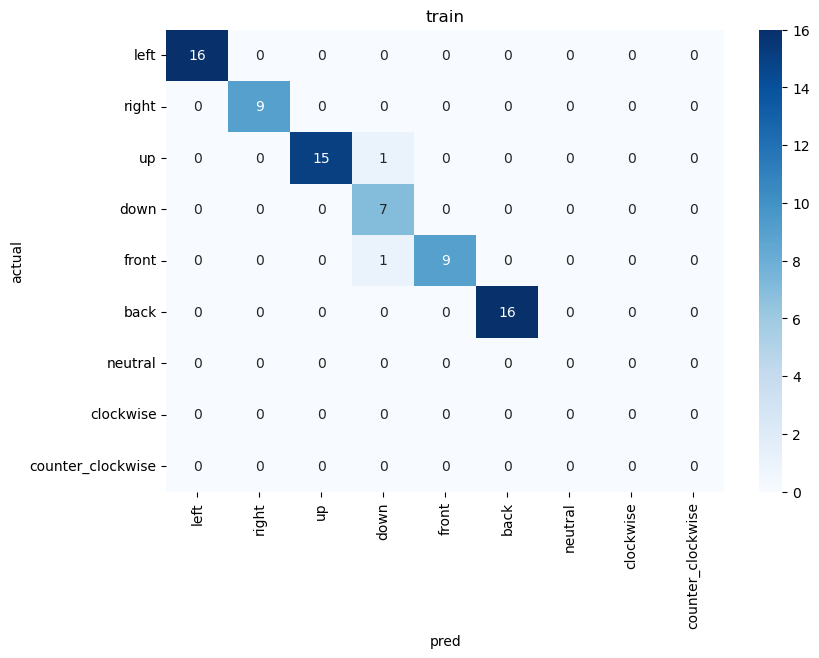

In [23]:
import seaborn as sns
def train_and_evaluate_svm(X_train, y_train, X_test, y_test):
    # Create the SVM classifier
#     svm_classifier = svm.SVC(kernel='rbf')
    svm_classifier = DecisionTreeClassifier(random_state=0)

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    # Perform prediction on the test set
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'SVM accuracy: {accuracy:.3%}')

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=gestures)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=gestures, yticklabels=gestures)
    plt.title('train')
    plt.xlabel('pred')
    plt.ylabel('actual')
    plt.show()
    
    return svm_classifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Perform training and testing with SVM
classifier = train_and_evaluate_svm(X_train, y_train, X_test, y_test)

# Create the SVM classifier
# classifier = svm.SVC(kernel='rbf')
# # classifier = LogisticRegression()

# # Train the classifier
# classifier.fit(X, y)
# # Perform prediction on the test set
# y_pred = classifier.predict(X)

# # Evaluate the model
# accuracy = accuracy_score(y, y_pred)
# print(f"Accuracy: {accuracy}")

In [24]:
with open('classifier_12152024_full.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [25]:
with open('./classifier_12152024_full.pkl', 'rb') as f:
    classifier = pickle.load(f)
y_pred = classifier.predict(X)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.991869918699187


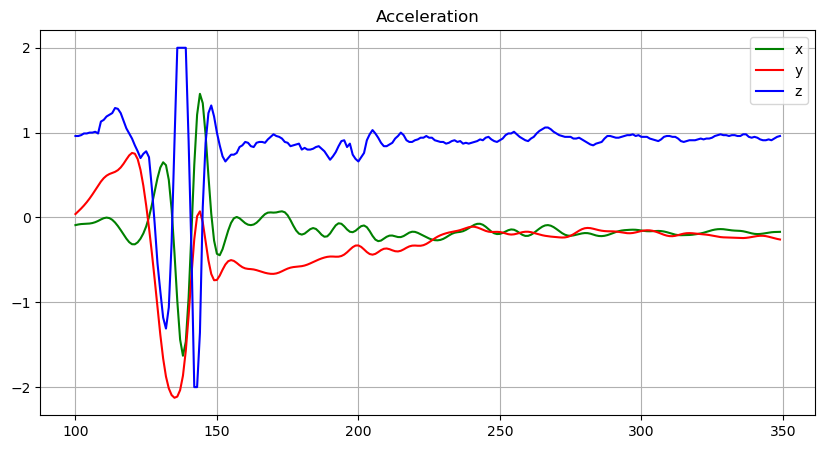

In [20]:
filenames = glob.glob(root + "front" + "_" + "20")
for file in filenames:
    data = pd.read_csv(file)
    data = data.iloc[100:350,:]
    data = remove_noise(data, 100)
#     print(data)
    plt.figure(figsize=(10,5))

    plt.plot(data.iloc[:,0], data['accel_x'], 'g-', label = 'filtered')
    plt.plot(data.iloc[:,0], data['accel_y'], 'r-', label = 'filtered')
    plt.plot(data.iloc[:,0], data['accel_z'], 'b-', label = 'filtered')
    plt.legend(['x', 'y', 'z']) 
    plt.title('Acceleration')
    plt.grid()
    plt.show()